In [1]:
import torch
from SpectralSVR import (
    SpectralSVR,
    LSSVR,
    FourierBasis,
    Burgers,
    Basis,
    to_real_coeff,
    StandardScaler,
    get_metrics,
    to_complex_coeff,
    resize_modes,
)
from matplotlib import pyplot as plt
from notebooks.utils import save_to_pgf

In [2]:
plt.rcParams.update(
    {
        # "text.usetex": True,  # use TeX for all texts
        "font.family": "serif",
        "font.size": 12,  # control font sizes of different elements
        # "pgf.rcfonts": False,    # don't setup fonts from rc parameters
        "figure.constrained_layout.use": True,
    }
)

In [3]:
def func(x: torch.Tensor, t: torch.Tensor):
    return x.unsqueeze(0).tile((t.shape[0], 1)) ** 2


def func_x(x: torch.Tensor, t: torch.Tensor):
    return 2 * x.unsqueeze(0).tile((t.shape[0], 1))


def func_xx(x: torch.Tensor, t: torch.Tensor):
    return 2 * torch.ones_like(x).unsqueeze(0).tile((t.shape[0], 1))


def func_t(x: torch.Tensor, t: torch.Tensor):
    return torch.zeros_like(x).unsqueeze(0).tile((t.shape[0], 1))

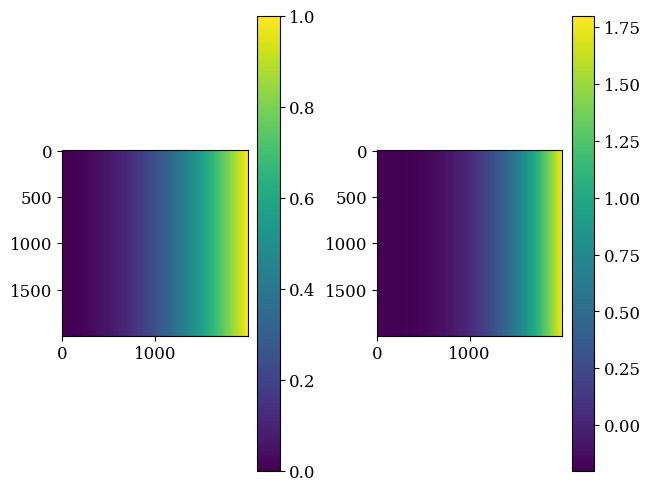

In [4]:
grid = FourierBasis.grid((slice(0, 1, 2000), slice(0, 1, 2000)))
x = grid[0, :, 1]
t = grid[:, 0, 0]
nu = 0.1
u_t = func_t(x, t)
u = func(x, t)
u_x = func_x(x, t)
u_xx = func_xx(x, t)
f = u_t + u * u_x - nu * u_xx
plt.figure(constrained_layout=True)
plt.subplot(121)
plt.imshow(u)
plt.colorbar()
plt.subplot(122)
plt.imshow(f)
plt.colorbar()

In [5]:
def get_function_values(u: Basis, f: Basis, res: tuple[slice, slice]):
    # get values at time resolution

    u_val, grid = u.get_values_and_grid(res=res)
    f_val = f.get_values(res=res)
    return u_val.real, f_val.real, grid


def get_time_dep_coeffs(
    u_val: torch.Tensor,
    f_val: torch.Tensor,
    target_modes: int | tuple[int, ...] | None = None,
) -> tuple[torch.Tensor, torch.Tensor]:
    # get the coefficients at each time step
    sample_time_shape = f_val.shape[:2]
    u_coeff = FourierBasis.transform(u_val.flatten(0, 1))
    f_coeff = FourierBasis.transform(f_val.flatten(0, 1))
    if target_modes is not None:
        u_coeff = resize_modes(u_coeff, target_modes=target_modes)
        f_coeff = resize_modes(f_coeff, target_modes=target_modes)
    u_coeff = u_coeff.unflatten(0, sample_time_shape)
    f_coeff = f_coeff.unflatten(0, sample_time_shape)
    return u_coeff, f_coeff


# input data shape = (sample_number, time, space)
# output data shape = (sample_number, time-1, space)
def get_time_pairs(
    u_val: torch.Tensor,
    f_val: torch.Tensor,
):
    # current time step
    uc = u_val[:, :-1]
    fc = f_val[:, :-1]
    # future time step
    uf = u_val[:, 1:]
    return uc, fc, uf


# feature (sample_number*(time-1), space*2) the times 2 is from the concatenation of solution and forcing term
# label (sample_number*(time-1), space)
def get_features_labels(
    uc: torch.Tensor,
    fc: torch.Tensor,
    uf: torch.Tensor,
    sample_size=-1,
    generator=None,
):
    x = to_real_coeff(torch.concat((uc, fc), dim=2).flatten(0, 1))
    # x = uc_flat
    y = (uf - uc).flatten(0, 1)
    if sample_size >= 0 and sample_size < len(x):
        sample_size = min(len(x), sample_size)
        sample_index = torch.randperm(sample_size, generator=generator)[:sample_size]
        x = x[sample_index]
        y = y[sample_index]
    return x, y
def get_model_rollout(
    model: SpectralSVR,
    u_init: torch.Tensor,  # function basis time dependent coefficients
    fh: torch.Tensor,
    spatial_res: slice,
    spatial_period: float,
    scaler: StandardScaler,
    # uh_temp: torch.Tensor,
) -> torch.Tensor:
    # fig, ax = plt.subplots()
    # im = ax.imshow(
    #     FourierBasis.inv_transform(to_complex_coeff(x_exact[:, :modes2])).real,
    #     aspect="auto",
    # )
    # fig.colorbar(im, ax=ax)

    uhc_list = []
    uhc = u_init  # initial condition
    uhc_list.append(uhc)
    fhc = fh[:, 0]
    for i in range(1, fh.shape[1]):
        xc = to_real_coeff(torch.cat((uhc, fhc), dim=1))
        duhf = model.regressor.predict(scaler.transform(xc))
        uhc = uhc + to_complex_coeff(duhf)  # next "initial" condition
        # uhc = uh_temp[:, i]
        uhc_list.append(uhc)
        fhc = fh[:, i]  # next forcing term

    uh_pred = torch.stack(uhc_list, dim=1)

    u_pred = (
        FourierBasis.inv_transform(
            uh_pred.flatten(0, 1),  # time dependent coeff inv transform
            res=spatial_res,
            periods=spatial_period,
        )
        .unflatten(0, uh_pred.shape[:2])
        .real
    )
    return u_pred


def plot_rollout(
    u_pred: torch.Tensor,
    u_target: torch.Tensor,
    nu: float,
    time_res: slice,
    spatial_res: slice,
    label: str,
    n: int = -1,
):
    # compute metrics
    metrics = get_metrics(
        u_pred.flatten(1), u_target.flatten(1)
    )  # flatten because pointwise metrics like r2 want it in matrix form
    u_target = u_target[n]
    u_pred = u_pred[n]

    # vmax = max(u_target.max().item(), u_pred.max().item())
    # vmin = min(u_target.min().item(), u_pred.min().item())
    # symetric vlim
    vlim = max(abs(u_target.max().item()), abs(u_target.min().item()))
    vmax = vlim
    vmin = -vlim
    extent = (
        spatial_res.start,
        spatial_res.stop,
        time_res.start,
        time_res.stop,
    )
    xlim = (
        spatial_res.start,
        spatial_res.stop,
    )
    ylim = (
        time_res.start,
        time_res.stop,
    )

    # pred
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        u_pred,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_pred_{nu}.pgf", plt=fig)
    plt.show()
    plt.close(fig)
    # target
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        u_target,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_target_{nu}.pgf", plt=fig)
    plt.show()
    plt.close(fig)
    # diff
    diff = u_target - u_pred
    fig, ax = plt.subplots(figsize=(3, 2))
    im = ax.imshow(
        diff,
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
        extent=extent,
        origin="lower",
        interpolation="none",
    )
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_ylabel("Time")
    ax.set_xlabel("Space")
    fig.colorbar(im, ax=ax)
    save_to_pgf(f"burgers_{label}_diff_{nu}.pgf", plt=fig)
    plt.show()
    plt.close(fig)

    return metrics

In [6]:
# time_domain = slice(0.0, 10.0, 2000)
# space_domain = slice(0.0, 2.0, 400)
# periods = (time_domain.stop - time_domain.start, space_domain.stop - space_domain.start)
# problem = Burgers()
# # nu = 0
# # nu_values = [0.01]
# nu_values = [0.0, 0.01, 0.1]
# noise_level = 0.1
# # noise_levels = [0.05, 0.1, 0.5]
# # noise_levels = [0.0]
# n = 500
# modes = (8, 8)
# spatial_res = space_domain
# nt = 200
# c = 3.0
# time_res = slice(time_domain.start, time_domain.stop, nt)
# space_period = space_domain.stop - space_domain.start
# data_metrics = {}
# spectral_results = {}
# function_results = {}
# rollout_spectral_results = {}
# rollout_function_results = {}
# exact_spectral_results = {}
# exact_function_results = {}
# sigma_values = {}
# data_fig = []
# data_ax = []
# interp_fig = []
# interp_ax = []
# scale_range = {}
# for i, nu in enumerate(nu_values):
#     label = f"{nu}"
#     generator = torch.Generator().manual_seed(42)
#     u_rand, f_rand = problem.generate(
#         basis=FourierBasis,
#         n=n,
#         modes=modes,
#         nu=nu,
#         u0="random",
#         f="random",
#         generator=generator,
#         time_domain=time_domain,
#         space_domain=space_domain,
#         time_dependent_coeff=False,
#     )
#     # for i, noise_level in enumerate(noise_levels):
#     # label = f"{noise_level*100}%"

#     # add noise
#     u_noisy = u_rand.perturb(std_ratio=noise_level, generator=generator)
#     f_noisy = f_rand.perturb(std_ratio=noise_level, generator=generator)

#     n_train = int(0.8 * n)
#     u_train, f_train, _ = get_function_values(
#         u_noisy[:n_train],
#         f_noisy[:n_train],
#         res=(time_res, space_res),
#         # res=(time_res, slice(space_res.start, space_res.stop, modes[1])),
#     )
#     uh_train, fh_train = get_time_dep_coeffs(u_train, f_train, target_modes=modes[1])
#     uc_train, fc_train, uf_train = get_time_pairs(uh_train, fh_train)
#     x_train, y_train = get_features_labels(
#         uc_train,
#         fc_train,
#         uf_train,
#         sample_size=8000,
#         generator=generator,
#     )
#     # Test data
#     u_test, f_test, grid = get_function_values(
#         u_noisy[n_train:],
#         f_noisy[n_train:],
#         res=(time_res, space_res),
#         # res=(time_res, slice(space_res.start, space_res.stop, modes[1])),
#     )
#     uh_test, fh_test = get_time_dep_coeffs(u_test, f_test, target_modes=modes[1])
#     uc_test, fc_test, uf_test = get_time_pairs(uh_test, fh_test)
#     x_test, y_test = get_features_labels(
#         uc_test,
#         fc_test,
#         uf_test,
#     )

#     # scale input data
#     scaler = StandardScaler().fit(x_train)
#     input_train = scaler.transform(x_train)
#     output_train = y_train
#     input_test = scaler.transform(x_test)
#     output_test = y_test

#     # test if the output is trivially computed from the inputs
#     # previous_time_step = to_real_coeff(x_train[:, : y_train.shape[1]]).contiguous()
#     # next_time_step = to_real_coeff(
#     #     y_train[:]
#     # ).contiguous()
#     # data_metrics = {
#     #     **data_metrics,
#     #     nu_label: get_metrics(next_time_step, previous_time_step),
#     # }
#     # Training
#     model = SpectralSVR(
#         FourierBasis(periods=space_period),
#         regressor=LSSVR(C=1.0),
#     )
#     model.train(input_train, output_train)
#     # Testing
#     test_metrics = model.test(input_test, output_test)
#     spectral_results = {
#         **spectral_results,
#         label: {
#             **test_metrics["spectral"],
#         },
#     }
#     function_results = {
#         **function_results,
#         label: {
#             **test_metrics["function value"],
#         },
#     }
#     # rollout testing
#     u = u_noisy[-1]
#     f = f_noisy[-1]
#     rollout_metrics = plot_rollout(
#         model, u, f, time_res, spatial_res, scaler, nu, "rollout"
#     )
#     rollout_spectral_results = {
#         **rollout_spectral_results,
#         label: {
#             **rollout_metrics[0],
#         },
#     }
#     rollout_function_results = {
#         **rollout_function_results,
#         label: {
#             **rollout_metrics[1],
#         },
#     }
#     # exact testing
#     x = torch.linspace(space_domain.start, space_domain.stop, modes[1])
#     t = torch.linspace(time_domain.start, time_domain.stop, nt)
#     u_t = func_t(x, t)
#     u_val = func(x, t)
#     u_x = func_x(x, t)
#     u_xx = func_xx(x, t)
#     f_val = u_t + u_val * u_x - nu * u_xx
#     # u_val = u_exact(x, t, nu, c)
#     u = FourierBasis(
#         FourierBasis.transform(u_val).unsqueeze(0), periods=periods, time_dependent=True
#     ).perturb(std_ratio=noise_level, generator=generator)
#     f = FourierBasis(
#         FourierBasis.transform(f_val).unsqueeze(0), periods=periods, time_dependent=True
#     ).perturb(std_ratio=noise_level, generator=generator)
#     exact_metrics = plot_rollout(
#         model, u, f, time_res, spatial_res, scaler, nu, "exact"
#     )
#     exact_spectral_results = {
#         **exact_spectral_results,
#         label: {
#             **exact_metrics[0],
#         },
#     }
#     exact_function_results = {
#         **exact_function_results,
#         label: {
#             **exact_metrics[1],
#         },
#     }
#     # interpretation
#     # tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
#     # interp_fig.append(tmp_fig)
#     # interp_ax.append(tmp_ax)
#     # fig_index = 2 * i
#     # corr = model.regressor.get_correlation_image().cpu()
#     # sorted = output_train.real[:, 4].sort()
#     # im = interp_ax[fig_index].imshow(
#     #     corr[sorted.indices.cpu(), :],
#     #     interpolation="none",
#     #     aspect="auto",
#     #     extent=(0, modes[0], corr.shape[0], 0),
#     # )
#     # interp_ax[fig_index].set_ylabel("samples")
#     # interp_ax[fig_index].set_xlabel("input coefficients")
#     # interp_fig[fig_index].colorbar(im, ax=interp_ax[fig_index])
#     # save_to_pgf(f"burgers_ci_{nu}.pgf", plt=interp_fig[fig_index])

#     # tmp_fig, tmp_ax = plt.subplots(figsize=(4, 3))
#     # interp_fig.append(tmp_fig)
#     # interp_ax.append(tmp_ax)
#     # fig_index = 2 * i + 1
#     # p_mat = model.regressor.get_p_matrix().cpu()
#     # im = interp_ax[fig_index].imshow(p_mat[:, :], interpolation="none", aspect="equal")
#     # interp_ax[fig_index].set_xlabel("output coefficients")
#     # interp_ax[fig_index].set_ylabel("input coefficients")
#     # interp_fig[fig_index].colorbar(im, ax=interp_ax[2 * i + 1])
#     # save_to_pgf(f"burgers_pm_{nu}.pgf", plt=interp_fig[fig_index])


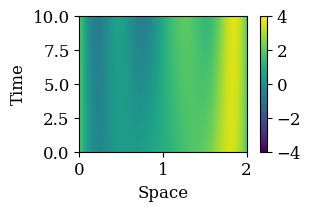

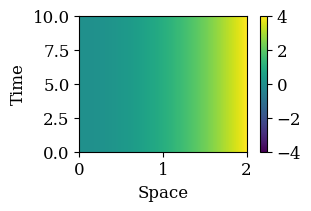

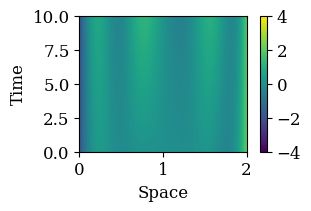

In [25]:
time_domain = slice(0.0, 10.0, 200)
space_domain = slice(0.0, 2.0, 400)
periods = (time_domain.stop - time_domain.start, space_domain.stop - space_domain.start)
problem = Burgers()
# nu = 0
nu_values = [0.01]
# nu_values = [0.0, 0.01, 0.1]
noise_level = 0.0
# noise_levels = [0.05, 0.1, 0.5]
c = 3.0  # constant of exact equation
n = 500
modes = (8, 8)
nt = 200
time_res = slice(time_domain.start, time_domain.stop, nt)
nx = 400
space_res = slice(space_domain.start, space_domain.stop, nx)
data_fig = []
data_ax = []
lssvr_function_results = {}
lssvr_spectral_results = {}
lssvr_exact_function_results = {}
exact_function_results = {}
scale_range = {}
for i, nu in enumerate(nu_values):
    label = f"{nu}"
    generator = torch.Generator().manual_seed(42)
    u_rand, f_rand = problem.generate(
        basis=FourierBasis,
        n=n,
        modes=modes,
        nu=nu,
        u0="random",
        f="random",
        generator=generator,
        time_domain=time_domain,
        space_domain=space_domain,
        time_dependent_coeff=False,
    )
    # for i, noise_level in enumerate(noise_levels):
    # label = f"{noise_level*100}%"

    # add noise
    u_noisy = u_rand.perturb(std_ratio=noise_level, generator=generator)
    f_noisy = f_rand.perturb(std_ratio=noise_level, generator=generator)

    # Split data by function sample
    n_train = int(0.8 * n)
    # Train data
    u_train, f_train, _ = get_function_values(
        u_noisy[:n_train],
        f_noisy[:n_train],
        res=(time_res, space_res),
        # res=(time_res, slice(space_res.start, space_res.stop, modes[1])),
    )
    uh_train, fh_train = get_time_dep_coeffs(u_train, f_train, target_modes=modes[1])
    uc_train, fc_train, uf_train = get_time_pairs(uh_train, fh_train)
    x_train, y_train = get_features_labels(
        uc_train,
        fc_train,
        uf_train,
        sample_size=8000,
        generator=generator,
    )
    # Test data
    u_test, f_test, grid = get_function_values(
        u_noisy[n_train:],
        f_noisy[n_train:],
        res=(time_res, space_res),
        # res=(time_res, slice(space_res.start, space_res.stop, modes[1])),
    )
    uh_test, fh_test = get_time_dep_coeffs(u_test, f_test, target_modes=modes[1])
    uc_test, fc_test, uf_test = get_time_pairs(uh_test, fh_test)
    x_test, y_test = get_features_labels(
        uc_test,
        fc_test,
        uf_test,
    )
    scale_range = {
        **scale_range,
        label: {
            "coeff": y_test.abs().flatten(1).max(1).values.mean().item(),
            "func": FourierBasis.inv_transform(y_test).real.max(1).values.mean().item(),
        },
    }

    # scale input data
    scaler = StandardScaler().fit(x_train)
    input_train = scaler.transform(x_train)
    output_train = y_train
    input_test = scaler.transform(x_test)
    output_test = y_test

    # test if the output is trivially computed from the inputs
    # previous_time_step = to_real_coeff(x_train[:, : y_train.shape[1]]).contiguous()
    # next_time_step = to_real_coeff(
    #     y_train[:]
    # ).contiguous()
    # data_metrics = {
    #     **data_metrics,
    #     nu_label: get_metrics(next_time_step, previous_time_step),
    # }
    # Training
    lssvr = SpectralSVR(
        FourierBasis(periods=space_domain.stop - space_domain.stop),
        regressor=LSSVR(C=1.0),
    )
    lssvr.train(input_train, output_train)
    test_results = lssvr.test(input_test, output_test)
    lssvr_function_results = {
        **lssvr_function_results,
        label: test_results["function value"],
    }
    lssvr_spectral_results = {
        **lssvr_spectral_results,
        label: test_results["spectral"],
    }
    # exact rollout
    u_t = func_t(grid[0, :, 1], grid[:, 0, 0])
    u_val = func(grid[0, :, 1], grid[:, 0, 0])
    u_x = func_x(grid[0, :, 1], grid[:, 0, 0])
    u_xx = func_xx(grid[0, :, 1], grid[:, 0, 0])
    f_val = u_t + u_val * u_x - nu * u_xx
    u_e = u_val.unsqueeze(0)
    f_basis = FourierBasis(
        FourierBasis.transform(f_val).unsqueeze(0), periods=periods, time_dependent=True
    ).perturb(std_ratio=noise_level, generator=generator)
    uh_exact = resize_modes(
        FourierBasis.transform(u_e.flatten(0, 1)), target_modes=8
    ).unsqueeze(0)
    fh_exact = resize_modes(
        FourierBasis.transform(
            f_basis.get_values(res=(time_res, space_res)).real.flatten(0, 1)
        ),
        target_modes=8,
    ).unsqueeze(0)
    u_lssvr = get_model_rollout(
        lssvr,
        uh_exact[:, 0],  # first time step coeffs
        fh_exact,
        space_res,
        spatial_period=u_noisy.periods[1],
        scaler=scaler,
    )
    lssvr_metrics = plot_rollout(
        u_lssvr,
        u_e,
        nu,
        time_res,
        space_res,
        label="exact_lssvr",
        n=-1,
    )
    lssvr_exact_function_results = {
        **lssvr_exact_function_results,
        label: lssvr_metrics,
    }


In [26]:
u_lssvr.shape

torch.Size([1, 200, 400])

In [31]:
coeff=FourierBasis.transform(u_e[0])
coeff_resized = resize_modes(coeff,(8,))
coeff.shape,coeff_resized.shape

(torch.Size([200, 400]), torch.Size([200, 8]))

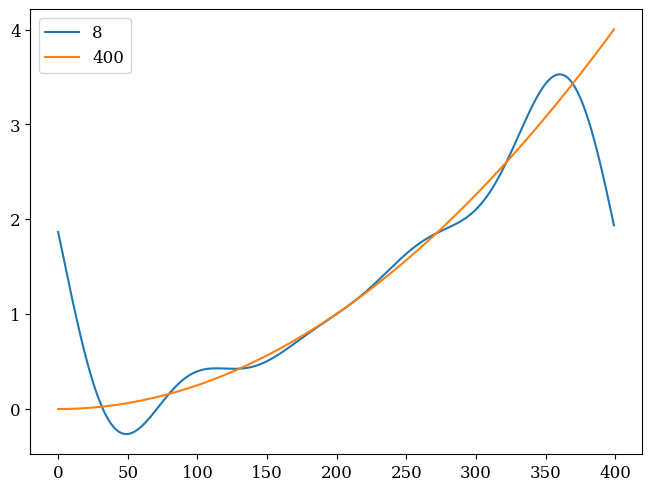

In [35]:
plt.plot(FourierBasis.inv_transform(coeff_resized,res=400)[60].real)
plt.plot(FourierBasis.inv_transform(coeff,res=400)[60].real)
# plt.plot(u_lssvr[0,60])
# plt.plot(u_e[0,60])
plt.legend(["8","400"])


In [11]:
u_lssvr.shape

torch.Size([1, 200, 400])